In [3]:
import sys
sys.stdout = open('full_output.txt', 'w', encoding='utf-8')


d:\DataMining\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\DataMining\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\DataMining\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\DataMining\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\DataMining\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\DataMining\.venv\lib\site-packag

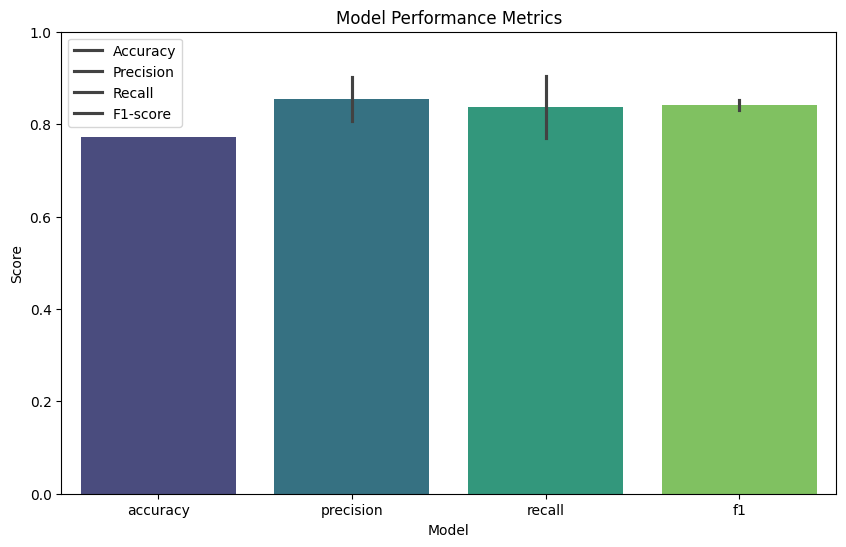

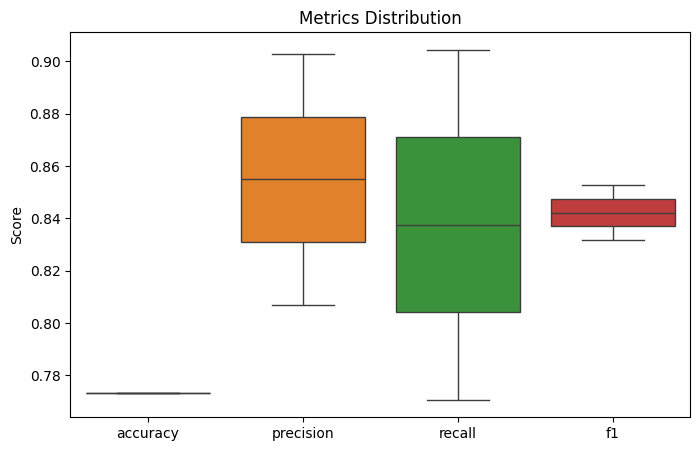

In [ ]:
# --- Part 1: Data Preprocessing ---
import pandas as pd
import numpy as np
import os
import spacy
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

terms_file = r"D:\DataMining\ACTER-master\en\wind\annotated\annotations\unique_annotation_lists\wind_en_terms.tsv"
df_terms = pd.read_csv(terms_file, sep="\t", header=None, names=["term", "label"])

valid_labels = ["Specific_Term", "Common_Term"]
df_terms = df_terms[df_terms["label"].isin(valid_labels)]

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000, min_df=3, stop_words='english', norm='l2')
X = tfidf_vectorizer.fit_transform(df_terms["term"])
y = df_terms["label"].map({"Specific_Term": 1, "Common_Term": 0})

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

def train_svm(X_train, y_train, X_test, y_test):
    print("\n--- Обучение SVM ---")
    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("Лучшие параметры для SVM:", grid_search.best_params_)

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    class_report = classification_report(y_test, y_pred)
    cv_accuracy = np.mean(cross_val_score(best_model, X, y, cv=5, scoring='accuracy'))

    return best_model, accuracy, precision, recall, f1, class_report, cv_accuracy

def train_lightgbm(X_train, y_train, X_test, y_test):
    print("\n--- Обучение LightGBM ---")
    param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}
    
    grid_search = GridSearchCV(
        LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1),  # Отключаем предупреждения
        param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=0  # Убираем лишний вывод
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("Лучшие параметры для LightGBM:", grid_search.best_params_)

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    class_report = classification_report(y_test, y_pred)
    cv_accuracy = np.mean(cross_val_score(best_model, X, y, cv=5, scoring='accuracy'))

    return best_model, accuracy, precision, recall, f1, class_report, cv_accuracy

results = {}

svm_model, *svm_metrics = train_svm(X_train_bal, y_train_bal, X_test, y_test)
lgbm_model, *lgbm_metrics = train_lightgbm(X_train_bal, y_train_bal, X_test, y_test)

results["SVM"] = {"accuracy": svm_metrics[0], "precision": svm_metrics[1], "recall": svm_metrics[2], "f1": svm_metrics[3], "classification_report": svm_metrics[4], "cv_accuracy": svm_metrics[5]}
results["LightGBM"] = {"accuracy": lgbm_metrics[0], "precision": lgbm_metrics[1], "recall": lgbm_metrics[2], "f1": lgbm_metrics[3], "classification_report": lgbm_metrics[4], "cv_accuracy": lgbm_metrics[5]}

def display_model_comparison():
    print("\n--- Сравнение моделей ---")
    print("| Модель      | Accuracy  | Precision | Recall  | F1-score | CV Accuracy |")
    print("|------------|----------|----------|--------|--------|------------|")
    for model_name, metrics in results.items():
        print(f"| {model_name:10} | {metrics['accuracy']:.4f} | {metrics['precision']:.4f} | {metrics['recall']:.4f} | {metrics['f1']:.4f} | {metrics['cv_accuracy']:.4f} |")

    print("\n--- Classification Reports ---")
    for model_name, metrics in results.items():
        print(f"\n--- {model_name} Classification Report ---\n{metrics['classification_report']}")

display_model_comparison()

def plot_metrics(results):
    metrics_df = pd.DataFrame(results).T[["accuracy", "precision", "recall", "f1"]]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=metrics_df, palette="viridis")
    plt.title("Model Performance Metrics")
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.ylim(0, 1)
    plt.legend(["Accuracy", "Precision", "Recall", "F1-score"])
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.boxplot(data=metrics_df)
    plt.title("Metrics Distribution")
    plt.ylabel("Score")
    plt.show()

plot_metrics(results)


## Experiment Report: Term Classification using SVM and LightGBM

This report evaluates the performance of two machine learning models, Support Vector Machine (SVM) and LightGBM, for the task of classifying terms into two categories: "Specific_Term" and "Common_Term". The experiment is divided into two parts: **Part 1: Data Preprocessing** and **Part 2: Model Training and Evaluation**.

### Part 2: Model Training and Evaluation

`Part 2` of the code focuses on training and evaluating the SVM and LightGBM models.  The process includes:

1.  **Data Splitting and Balancing:** The preprocessed data is split into training and testing sets using `train_test_split`, with 20% of the data reserved for testing and stratified sampling to maintain class proportions. To address potential class imbalance, SMOTE (Synthetic Minority Over-sampling Technique) is applied to the *training* data to oversample the minority class.
2.  **Model Training and Hyperparameter Tuning:**
    *   **SVM Model:** An SVM classifier with a Radial Basis Function (RBF) kernel and linear kernel is trained. GridSearchCV is used to find the optimal hyperparameters (`C` and `kernel`) using 3-fold cross-validation and accuracy as the scoring metric. Class weights are balanced to handle potential class imbalance within the models themselves.
    *   **LightGBM Model:** A LightGBM classifier is trained. GridSearchCV is employed to determine the best hyperparameters (`n_estimators`, `learning_rate`, `max_depth`) via 3-fold cross-validation, again using accuracy as the scoring metric and balancing class weights.
3.  **Model Evaluation:** Both models are evaluated on the held-out test set. The evaluation metrics used are:
    *   Accuracy
    *   Precision
    *   Recall
    *   F1-score
    *   Classification Report (providing detailed precision, recall, and F1-score for each class)
    *   Cross-Validation Accuracy (average accuracy from 5-fold cross-validation on the entire dataset)
